In [1]:
from img_cap_lib import *
# imports
import torch
import torchvision
import torchtext
from torchtext.vocab import vocab, GloVe, Vectors
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import os
from PIL import Image
import string
from collections import OrderedDict, Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
import pickle
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import nltk

# Modellpfad festlegen

In [2]:
model_path = "models/standart_model_with_normalisation.pt"

# Daten herunterladen

In [3]:
data_download("flickr8k")

Data already exi sts at flickr8k


# Modell mit Normalisierung

## Modell laden

In [4]:
# load model
model_stats = torch.load(model_path, map_location=torch.device('cpu'))
model = load_captioning_model(model_stats)

## Preprocessing

In [5]:
# caption preprocessing
embedding_dim = 300
min_frequency = 1

captions = pd.read_csv("flickr8k/captions.txt")
caption_preprocessor = CaptionPreprocessor(embedding=model_stats['embedding'].embedding_matrix, captions_path="flickr8k/captions.txt", vocabulary=model_stats['embedding'].vocabulary ,captions=captions, embedding_dim=embedding_dim, min_frequency=min_frequency)
caption_preprocessor.preprocess()

# image preprocessing
img_preprocessor = ImagePreprocessor(normalize=True, image_folder_path="flickr8k")
img_preprocessor.preprocess_images()

Shape captions: (40460, 2)


/Users/ronnyschneeberger/Documents/FHNW/HS22/del-image-captioning/img_cap_lib.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.captions.caption = self.captions.caption.apply(lambda x: x.strip("."))


Shape captions after filtering: (39749, 3)
Removed Captions:  711 , in Percent:  1.76
transformed_images folder already exists. No preprocessing necessary.


## Datensplit und DataLoader

In [7]:
# create split
training_data, test_data = train_test_split(caption_preprocessor.captions, test_size=0.15, random_state=42)

# create datasets
train_dataset = FlickrDataset(captions=training_data, embedding=model.embedding, image_folder="flickr8k")
test_dataset = FlickrDataset(captions=test_data, embedding=model.embedding, image_folder="flickr8k")

# create dataloaders
batch_size = 8
train_loader = FlickrLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = FlickrLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [8]:
with open("scores/standart_test_scores.pkl", 'rb') as f:
    test_scores = pickle.load(f)

with open("scores/standart_train_scores.pkl", 'rb') as f:
    train_scores = pickle.load(f)

In [11]:
def visualize_model_results(model, df:pd.DataFrame, n_samples=8):
    sample = df.sample(n_samples)

    for i, image_path in enumerate(sample.image.values):
        input = torchvision.io.read_image("flickr8k/transformed_images/" + image_path).float()
        image = Image.open("flickr8k/images/" + image_path)
        plt.imshow(image)
        plt.show()
        print("predicted")
        predicted_caption = model.forward(input.unsqueeze(0))
        predicted_caption = " ".join(predicted_caption)
        predicted_caption = predicted_caption.split('<EOS>')[0]
        predicted_caption = predicted_caption.lstrip('<SOS>')
        print(20*"-")
        print(predicted_caption + "\n")
        print("caption")
        print(20*"-")
        caption = sample["caption"].iloc[i]
        caption = " ".join(eval(caption))
        caption = caption.split('<EOS>')[0]
        caption = caption.lstrip('<SOS>')
        print(caption + "\n")

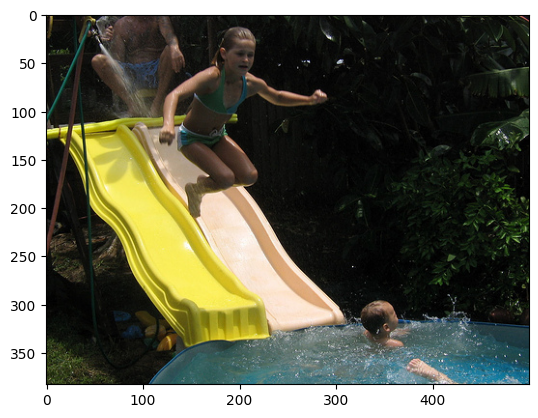

predicted
--------------------
 a little girl jumps from the yellow ladder into the swimming pool 

caption
--------------------
 a little girl jumps from the yellow ladder into the swimming pool 



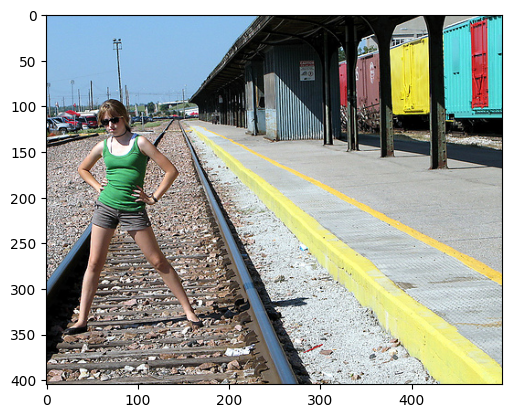

predicted
--------------------
 a girl wearing a pink coat jumps over her hair s feet in the air 

caption
--------------------
 a girl poses on the train tracks near a station 



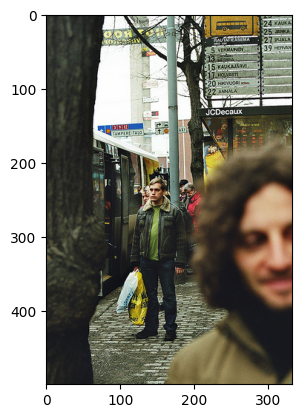

predicted
--------------------
 people walking down the street and past an open bus 

caption
--------------------
 a man stands next to a bus 



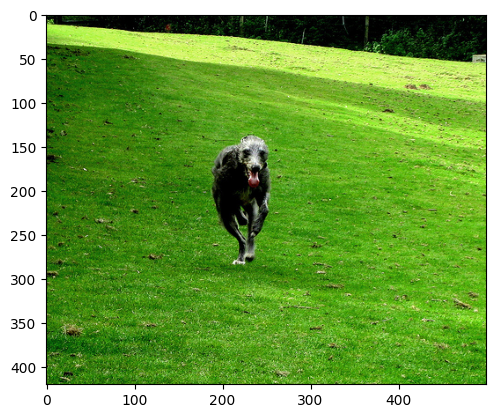

predicted
--------------------
 a gray dog is running up a hill with a small mountain in the background 

caption
--------------------
 a dog runs across the grass 



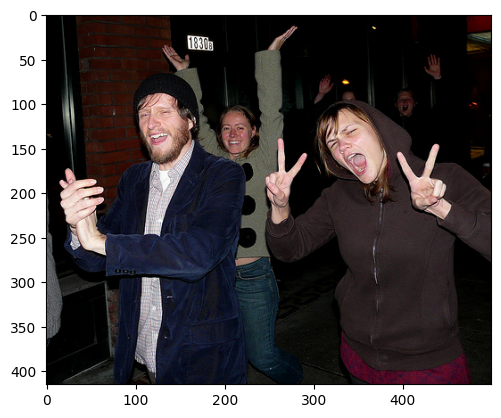

predicted
--------------------
 a group of people who look very excited about something stand outdoors 

caption
--------------------
 a group of people who look very excited about something stand outdoors 



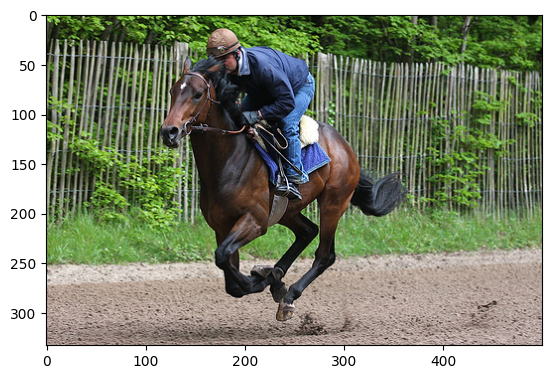

predicted
--------------------
 a jockey in blue rides a horse at a galloping pace 

caption
--------------------
 a jockey in blue rides a horse at a galloping pace 



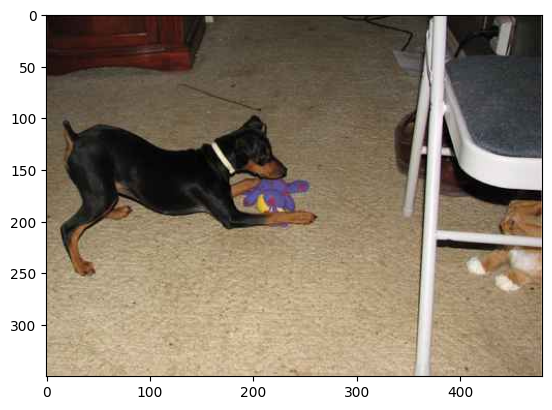

predicted
--------------------
 a dog plays with a stuffed animal 

caption
--------------------
 the dog plays with a purple toy near a cat 



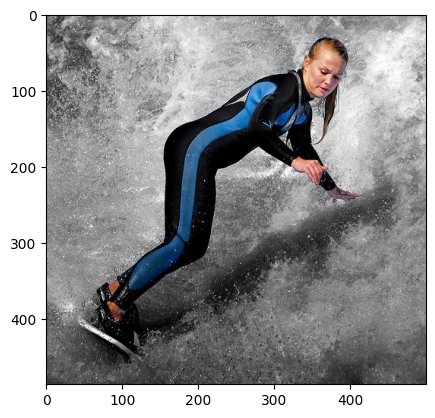

predicted
--------------------
 a woman in a blue and black wetsuit is water boarding 

caption
--------------------
 a girl in a black and blue wetsuit is surfing 



In [12]:
visualize_model_results(model, training_data)

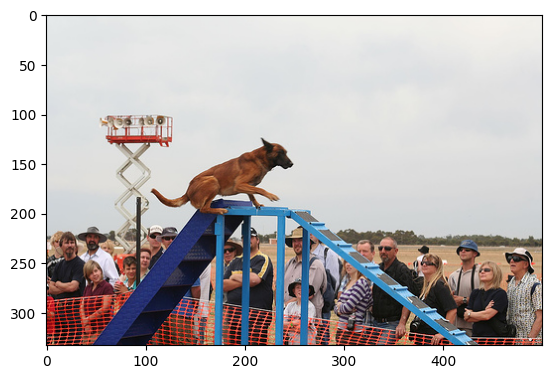

predicted
--------------------
 a dog is running down a ramp and his dog is on the stands 

caption
--------------------
 a crowd is watching a dog climb up a staircase 



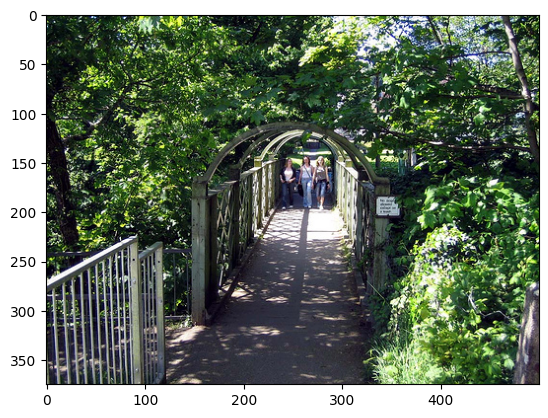

predicted
--------------------
 three girls walking along an arched garden pathway 

caption
--------------------
 three women walking through a tunnel in a park 



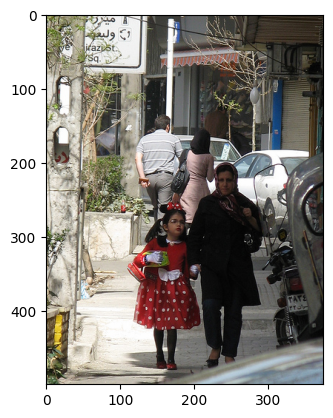

predicted
--------------------
 a young girl dressed in a minnie mouse outfit and an older woman walking down the sidewalk 

caption
--------------------
 two indian women walk down a road 



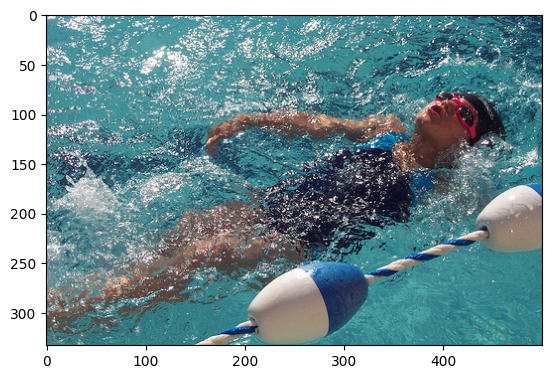

predicted
--------------------
 a young girl in swim goggles does the backstroke in a pool 

caption
--------------------
 the girl wearing pink goggles is in the swimming pool doing the backstroke 



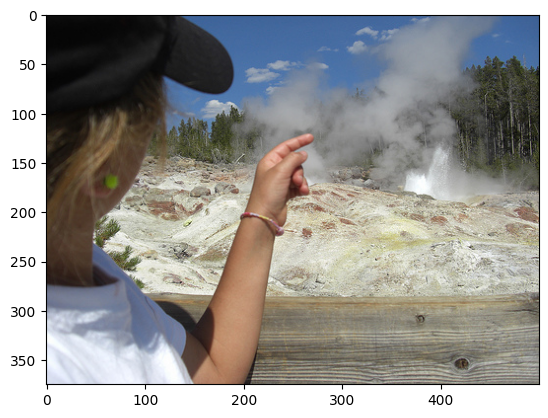

predicted
--------------------
 a woman in a white tshirt points at a geyser 

caption
--------------------
 a person is pointing at a geyser 



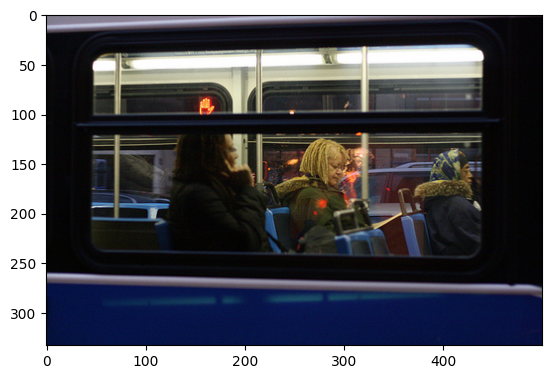

predicted
--------------------
 three women sit on the subway one talks on the phone while the others read 

caption
--------------------
 people seen through the window of a bus 



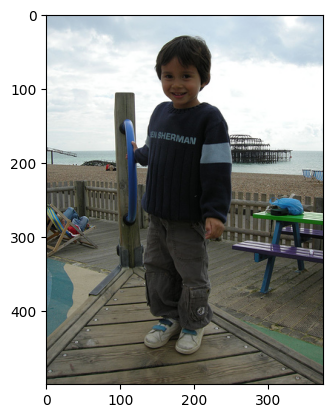

predicted
--------------------
 a young boy holds onto a blue handle on a pier 

caption
--------------------
 a little boy is smiling for the camera on a playground 



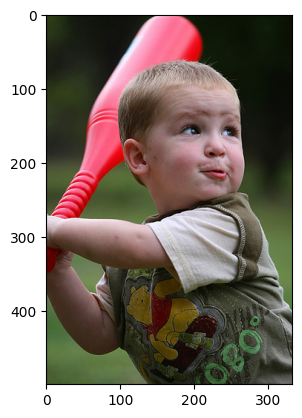

predicted
--------------------
 a little boy in a winnie the pooh tshirt is waiting to swing his red bat 

caption
--------------------
 a little blonde boy in a winnie the pool tshirt holds up a red plastic bat 



In [14]:
visualize_model_results(model, test_data)